In [2]:
# W bazie danych TRPrzychodnia zrobić zestawienie zawierające następujące dane:
# - nazwisko i imię lekarza ,
# - liczbę wizyt oraz sumę opłat za wizyty zrealizowane w 30 dniach,
# dla  których w roku 2021 osiągnięto największe sumaryczne  dzienne wartości opłat za wizyty.
# W zestawieniu uwzględnić dwoch lekarzy którzy osiągnęli największe wartości sumy opłat.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy as sa
import matplotlib as mpl

from matplotlib.cm import ScalarMappable
from collections import defaultdict
from matplotlib.colors import Normalize
from shapely.wkt import loads
from scipy.interpolate import griddata
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

# DB Connection
base_connection = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=tester1.wwsi.edu.pl,50223;uid=student;pwd=ciekawski"
air_polution_db = f"{base_connection};DATABASE=TRPrzychodnia"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": air_polution_db})
engine = create_engine(connection_url)

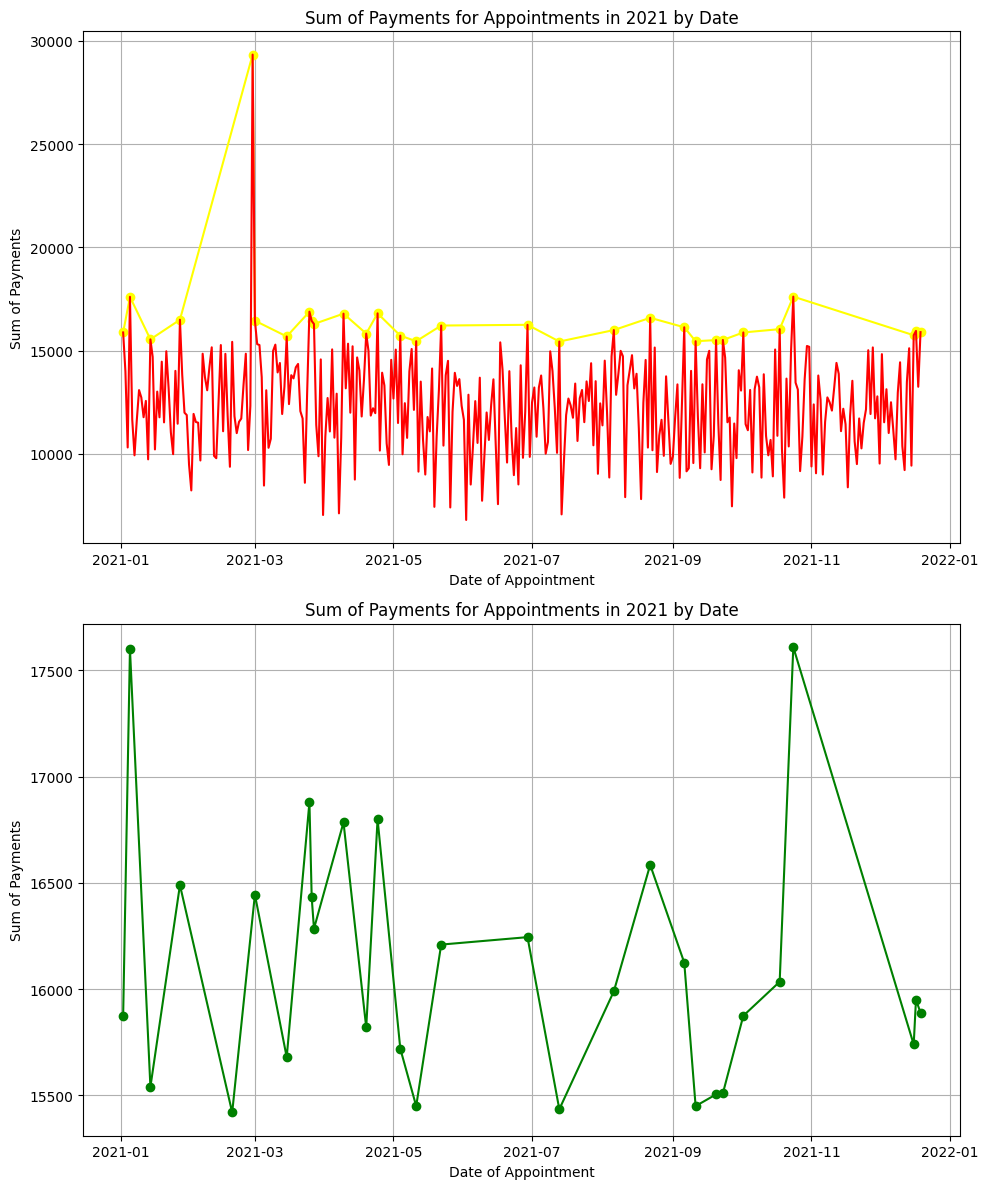

In [3]:
bestDaysData = None
bestDaysQuery = """
    SELECT
        TOP 30
        DataWizyty
        , SUM(Oplata) AS SumaKwoty
    FROM dbo.Wizyty
    WHERE YEAR(DataWizyty) = 2021
    GROUP BY DataWizyty
    ORDER BY SumaKwoty DESC
"""
allDaysData = None
allDaysQuery = """
    SELECT
        DataWizyty
        , SUM(Oplata) AS SumaKwoty
    FROM dbo.Wizyty
    WHERE DataWizyty >= '2021-01-02' AND DataWizyty <= '2021-12-19'
    GROUP BY DataWizyty
    ORDER BY SumaKwoty DESC
"""

sanitizedDaysData = None
sanitizedDaysDataQuery = """
    SELECT
        TOP 30
        DataWizyty
        , SUM(Oplata) AS SumaKwoty
    FROM dbo.Wizyty
    WHERE YEAR(DataWizyty) = 2021 AND DataWizyty != '2021-02-28'
    GROUP BY DataWizyty
    ORDER BY SumaKwoty DESC
"""

with engine.begin() as conn:
    bestDaysData = pd.read_sql_query(sa.text(bestDaysQuery), conn)

with engine.begin() as conn:
    allDaysData = pd.read_sql_query(sa.text(allDaysQuery), conn)

with engine.begin() as conn:
    sanitizedDaysData = pd.read_sql_query(sa.text(sanitizedDaysDataQuery), conn)
    
bestDaysData = bestDaysData.sort_values(by='DataWizyty')
allDaysData = allDaysData.sort_values(by='DataWizyty')
sanitizedDaysData = sanitizedDaysData.sort_values(by='DataWizyty')

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].plot(bestDaysData['DataWizyty'], bestDaysData['SumaKwoty'], marker='o', linestyle='-', color='yellow')
axs[0].plot(allDaysData['DataWizyty'], allDaysData['SumaKwoty'], linestyle='-', color='red')
axs[1].plot(sanitizedDaysData['DataWizyty'], sanitizedDaysData['SumaKwoty'], marker='o', linestyle='-', color='green')

for i in (0, 1):
    axs[i].set_xlabel('Date of Appointment')
    axs[i].set_ylabel('Sum of Payments')
    axs[i].set_title('Sum of Payments for Appointments in 2021 by Date')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

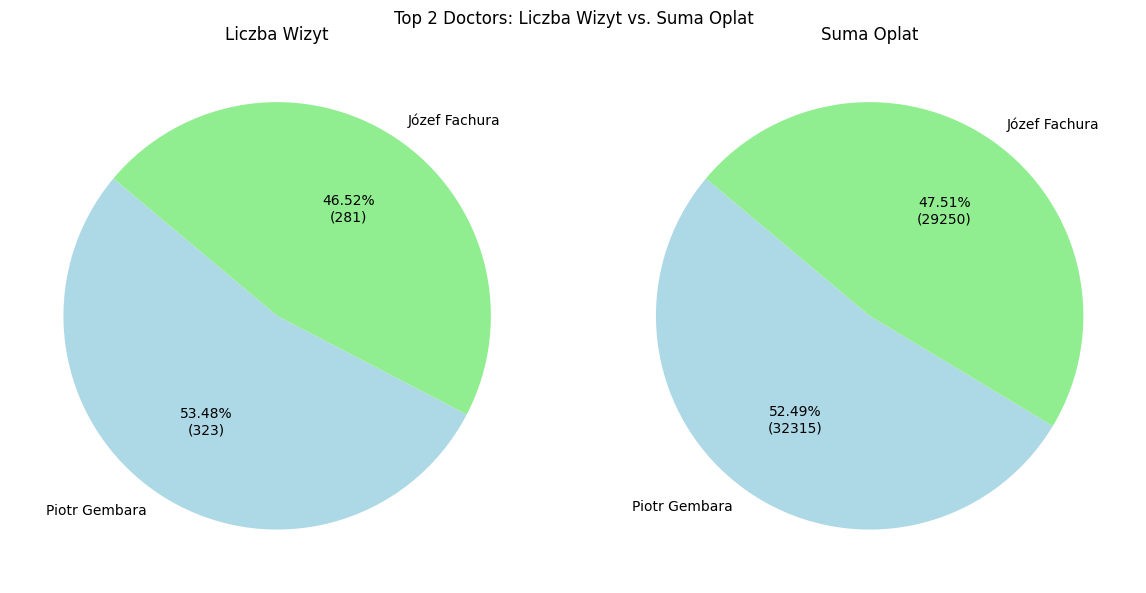

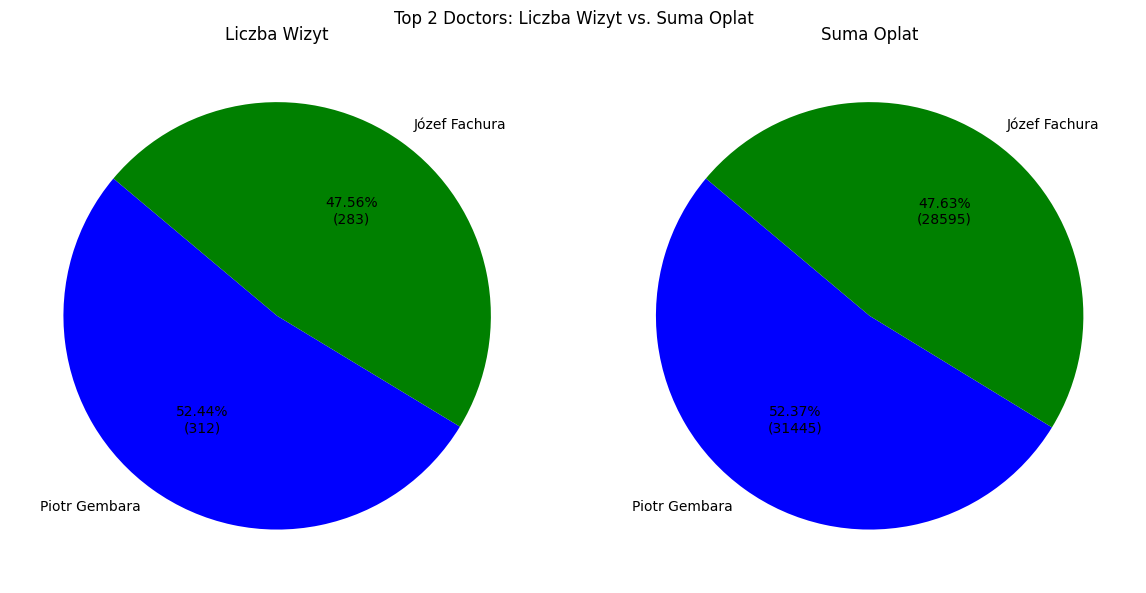

In [4]:
bestDoctorsData = None
bestDoctorsQuery = f"""
WITH BestDays AS (
    {bestDaysQuery}
), DoctorsExtended AS (
    SELECT
        L.Imie
        , L.Nazwisko
        , COUNT(W.IdWizyty) AS LiczbaWizyt
        , SUM(W.Oplata) AS SumaOplat
    FROM dbo.Lekarze AS L
    INNER JOIN dbo.Wizyty AS W
        ON W.IdLekarza = L.IdLekarza
    INNER JOIN BestDays AS BD
        ON W.DataWizyty = BD.DataWizyty
    GROUP BY L.Imie, L.Nazwisko
)
SELECT TOP 2 * FROM DoctorsExtended ORDER BY SumaOplat DESC
"""

sanitizedBestDoctorsData = None
sanitizedBestDoctorsQuery = f"""
WITH BestDays AS (
    {sanitizedDaysDataQuery}
), DoctorsExtended AS (
    SELECT
        L.Imie
        , L.Nazwisko
        , COUNT(W.IdWizyty) AS LiczbaWizyt
        , SUM(W.Oplata) AS SumaOplat
    FROM dbo.Lekarze AS L
    INNER JOIN dbo.Wizyty AS W
        ON W.IdLekarza = L.IdLekarza
    INNER JOIN BestDays AS BD
        ON W.DataWizyty = BD.DataWizyty
    GROUP BY L.Imie, L.Nazwisko
)
SELECT TOP 2 * FROM DoctorsExtended ORDER BY SumaOplat DESC
"""


with engine.begin() as conn:
    bestDoctorsData = pd.read_sql_query(sa.text(bestDoctorsQuery), conn)

with engine.begin() as conn:
    sanitizedBestDoctorsData = pd.read_sql_query(sa.text(sanitizedBestDoctorsQuery), conn)
    
# Plotting
def autopctFormat(values):
    def nestedFormat(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return nestedFormat

labelsWithFullNames = bestDoctorsData['Imie'] + " " + bestDoctorsData['Nazwisko']

# Recreating pie charts with the new labels format
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Pie chart for LiczbaWizyt
axs[0].pie(bestDoctorsData['LiczbaWizyt'], labels=labelsWithFullNames, 
           autopct=autopctFormat(bestDoctorsData['LiczbaWizyt']),
           startangle=140, colors=['lightblue', 'lightgreen'])
axs[0].set_title('Liczba Wizyt')

# Pie chart for SumaOplat
axs[1].pie(bestDoctorsData['SumaOplat'], labels=labelsWithFullNames, 
           autopct=autopctFormat(bestDoctorsData['SumaOplat']),
           startangle=140, colors=['lightblue', 'lightgreen'])
axs[1].set_title('Suma Oplat')

plt.suptitle('Top 2 Doctors: Liczba Wizyt vs. Suma Oplat')
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Pie chart for LiczbaWizyt
axs[0].pie(sanitizedBestDoctorsData['LiczbaWizyt'], labels=labelsWithFullNames, 
           autopct=autopctFormat(sanitizedBestDoctorsData['LiczbaWizyt']),
           startangle=140, colors=['blue', 'green'])
axs[0].set_title('Liczba Wizyt')

# Pie chart for SumaOplat
axs[1].pie(sanitizedBestDoctorsData['SumaOplat'], labels=labelsWithFullNames, 
           autopct=autopctFormat(sanitizedBestDoctorsData['SumaOplat']),
           startangle=140, colors=['blue', 'green'])
axs[1].set_title('Suma Oplat')

plt.suptitle('Top 2 Doctors: Liczba Wizyt vs. Suma Oplat')
plt.tight_layout()

plt.show()

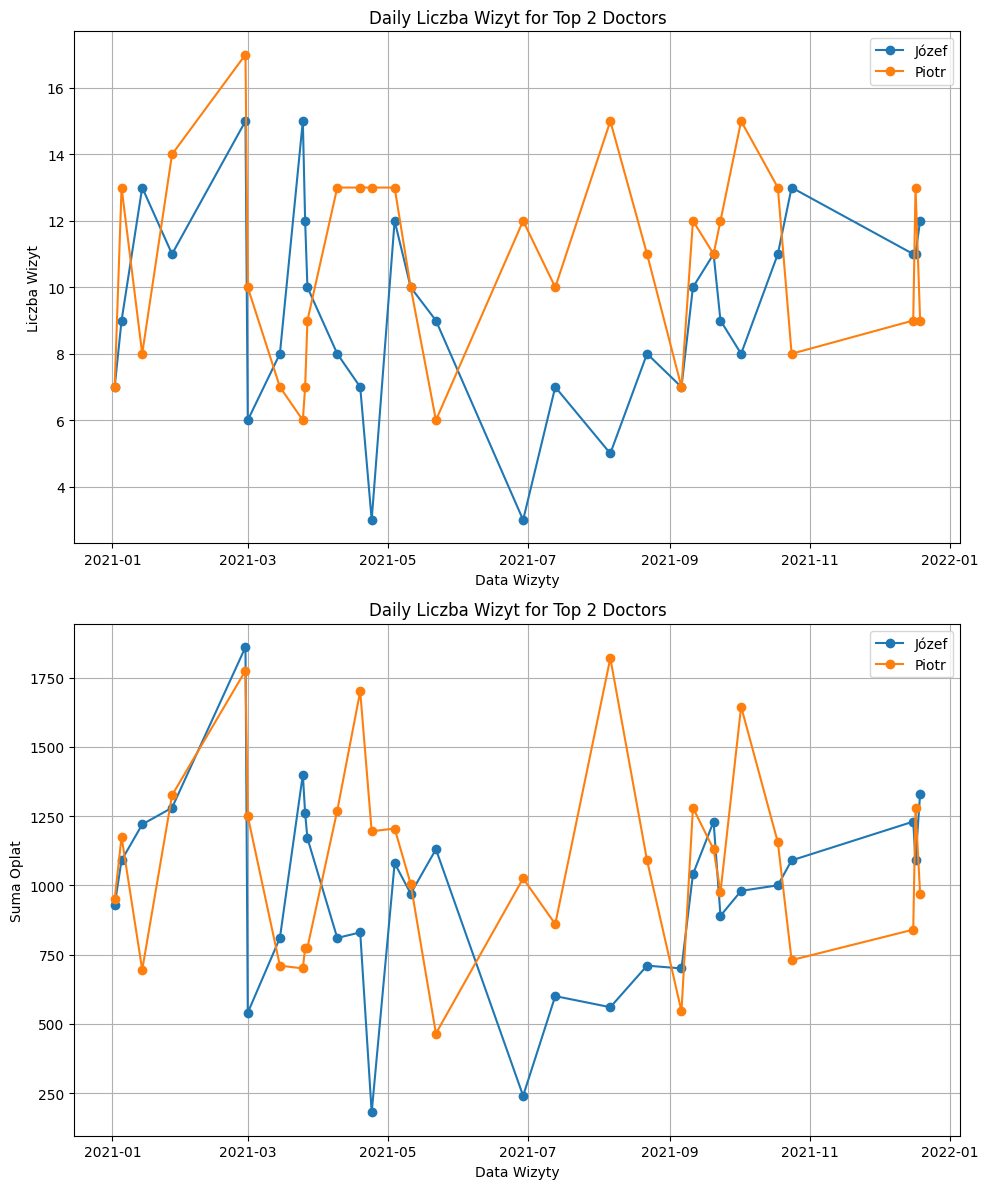

In [5]:
bestDoctorsDailyData = None
bestDoctorsDailyQuery = f"""
WITH BestDays AS (
    {bestDaysQuery}
), BestDoctorsMid AS (
    SELECT
        L.IdLekarza
        , SUM(W.Oplata) AS SumaOplat
    FROM dbo.Lekarze AS L
    INNER JOIN dbo.Wizyty AS W
        ON W.IdLekarza = L.IdLekarza
    INNER JOIN BestDays AS BD
        ON W.DataWizyty = BD.DataWizyty
    GROUP BY L.IdLekarza, L.Imie, L.Nazwisko
), BestDoctors AS (
    SELECT 
        TOP 2 
        * 
    FROM BestDoctorsMid ORDER BY SumaOplat DESC
), DoctorsExtended AS (
    SELECT
        L.IdLekarza
        , L.Imie
        , L.Nazwisko
        , W.DataWizyty
        , COUNT(W.IdWizyty) AS LiczbaWizyt
        , SUM(W.Oplata) AS SumaOplat
    FROM dbo.Lekarze AS L
        INNER JOIN dbo.Wizyty AS W
            ON W.IdLekarza = L.IdLekarza
        INNER JOIN BestDays AS BD
           ON W.DataWizyty = BD.DataWizyty
    GROUP BY L.IdLekarza, L.Imie, L.Nazwisko, W.DataWizyty
)
SELECT
    DoctorsExtended.*
FROM DoctorsExtended
INNER JOIN BestDoctors
    ON DoctorsExtended.IdLekarza = BestDoctors.IdLekarza
"""

with engine.begin() as conn:
    bestDoctorsDailyData = pd.read_sql_query(sa.text(bestDoctorsDailyQuery), conn)

bestDoctorsDailyData = bestDoctorsDailyData.sort_values(by='DataWizyty')
bestDoctorsDailyData = bestDoctorsDailyData.groupby('Imie')

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Line plot for Liczba Wizyt
for name, group in bestDoctorsDailyData:
    axs[0].plot(group['DataWizyty'], group['LiczbaWizyt'], marker='o', linestyle='-', label=name)
    axs[1].plot(group['DataWizyty'], group['SumaOplat'], marker='o', linestyle='-', label=name)

axs[0].set_title('Daily Liczba Wizyt for Top 2 Doctors')
axs[0].set_xlabel('Data Wizyty')
axs[0].set_ylabel('Liczba Wizyt')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Daily Liczba Wizyt for Top 2 Doctors')
axs[1].set_xlabel('Data Wizyty')
axs[1].set_ylabel('Suma Oplat')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()